# **Step 1:** Setup and Import Libraries

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# **Step 2:** Load and Preprocess Data

In [64]:
# Set paths
train_images_path = 'data/training/images'
train_masks_path = 'data/training/groundtruth'
test_images_path = 'data/test_set_images'

# Load images and masks
def load_data(image_path, mask_path):
    images = []
    masks = []
    for file_name in sorted(os.listdir(image_path)):
        img = img_to_array(load_img(os.path.join(image_path, file_name), color_mode="grayscale")) / 255.0
        images.append(img)
    for file_name in sorted(os.listdir(mask_path)):
        mask = img_to_array(load_img(os.path.join(mask_path, file_name), color_mode="grayscale")) / 255.0
        masks.append(mask)
    return np.array(images), np.array(masks)

train_images, train_masks = load_data(train_images_path, train_masks_path)
print(f"Training images shape: {train_images.shape}")
print(f"Training masks shape: {train_masks.shape}")

Training images shape: (100, 400, 400, 1)
Training masks shape: (100, 400, 400, 1)


In [65]:
from tensorflow.image import resize

# Resize images to ensure compatibility with the model
def preprocess_data(images, masks, img_size=(128, 128)):
    images_resized = np.array([resize(img, img_size).numpy() for img in images])
    masks_resized = np.array([resize(mask, img_size).numpy() for mask in masks])
    return images_resized, masks_resized

IMG_SIZE = (128, 128)  # Resize images to 128x128
train_images, train_masks = preprocess_data(train_images, train_masks, img_size=IMG_SIZE)

# **Step 3:** Training & Evaluation

## Trial 1: Basic Trial

### Model Architecture (U-Net)

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_66[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_68[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_70[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 64, 64,    │          0 │ conv2d_71[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 64, 64,    │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 384)              │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │    442,496 │ concatenate_12[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_72[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 128, 128,  │          0 │ conv2d_73[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128, 128,  │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 192)              │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_13[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_74[0][0] 

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [54]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7421 - loss: 0.6599 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.6032 - val_mean_io_u: 1.0000
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7495 - loss: 0.5744 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.4726 - val_mean_io_u: 1.0000
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7437 - loss: 0.5107 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.4724 - val_mean_io_u: 1.0000
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7537 - loss: 0.4843 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.4834 - val_mean_io_u: 1.0000
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7488 - loss: 0.4945 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.4710 - val_mean_io_u: 1.0000
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7521 - loss: 0.4812 - mean_io_u: 1.0000 - val_accuracy: 0.7731 - val_loss: 0.4681 - val_mean_io_u:

In [57]:
model.save("model-1.keras")

### Evaluate and Visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


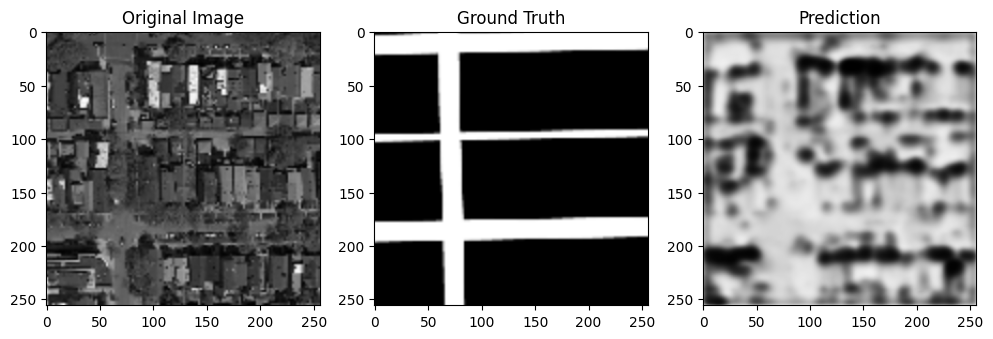

In [74]:
# Predict on validation set
predictions = model.predict(X_val)

# Visualize predictions
def visualize_predictions(images, masks, preds, idx):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(masks[idx].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(preds[idx].squeeze(), cmap='gray')
    plt.show()

visualize_predictions(X_val, y_val, predictions, idx=0)


Results are not satisfying.

---

## Trial 2: Trying Deeper Model Architechture

### Model Architecture (U-Net)

In [66]:
from tensorflow.keras.layers import Dropout

def unet_v2(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

model_v2 = unet_v2(input_size=(256, 256, 1))
model_v2.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_v2.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 256, 256,  │        640 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256, 256,  │          0 │ conv2d_122[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 256, 256,  │     36,928 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 128, 128,  │          0 │ conv2d_123[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128, 128,  │          0 │ conv2d_124[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 128, 128,  │    147,584 │ dropout_13[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ conv2d_125[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_24… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64, 64,    │          0 │ conv2d_126[0][0]  │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 64, 64,    │    590,080 │ dropout_14[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_127[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_25… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32, 32,    │          0 │ conv2d_128[0][0]  │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ dropout_15[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_19    │ (None, 64, 64,    │          0 │ conv2d_129[0][0]

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Generate augmented data
def data_generator(images, masks, batch_size=16):
    image_gen = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_gen = mask_datagen.flow(masks, batch_size=batch_size, seed=42)
    while True:
        yield next(image_gen), next(mask_gen)

train_generator = data_generator(X_train, y_train)
val_generator = data_generator(X_val, y_val)

In [68]:
# Preprocess data to 256x256
train_images, train_masks = preprocess_data(train_images, train_masks, img_size=(256, 256))
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Train model
history_v2 = model_v2.fit(train_generator,
                          steps_per_epoch=len(X_train) // 16,
                          validation_data=val_generator,
                          validation_steps=len(X_val) // 16,
                          epochs=20)

# Save the model
model_v2.save("model-2.keras")


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 114s 22s/step - accuracy: 0.3724 - loss: 0.6910 - val_accuracy: 0.7494 - val_loss: 0.6651
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 19s/step - accuracy: 0.7254 - loss: 0.6106 - val_accuracy: 0.7494 - val_loss: 0.4728
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.7021 - loss: 0.5384 - val_accuracy: 0.7494 - val_loss: 0.5387
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 19s/step - accuracy: 0.6931 - loss: 0.5129 - val_accuracy: 0.7494 - val_loss: 0.4744
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.7239 - loss: 0.5005 - val_accuracy: 0.7494 - val_loss: 0.5251
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.7255 - loss: 0.4932 - val_accuracy: 0.7494 - val_loss: 0.4982
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.7067 - loss: 0.5095 - val_accuracy: 0.7494 - val_loss: 0.4955
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.7182 - loss: 0.4934 - val_accuracy: 0.7494 - val_loss: 0.4985

### Evaluate and Visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


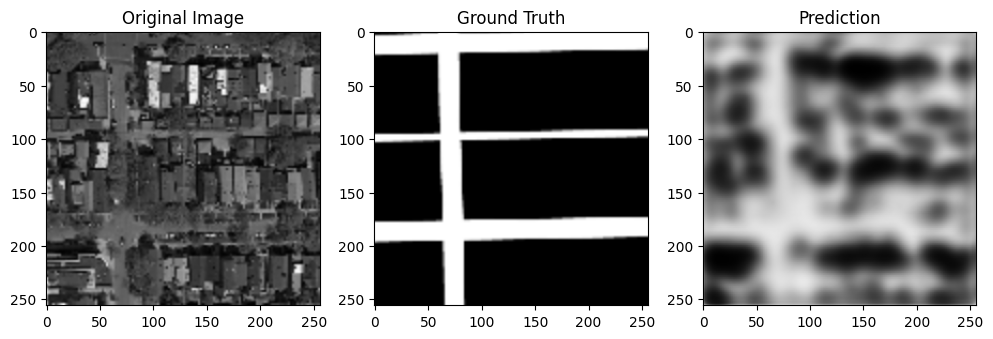

In [69]:
# Predict on validation set
predictions_v2 = model_v2.predict(X_val)

# Visualize predictions
visualize_predictions(X_val, y_val, predictions_v2, idx=0)

### Enhancements in Trial 2:
* **Data Augmentation:** Simulates varied inputs for robustness.
* **Deeper U-Net:** Added depth and Dropout to enhance feature extraction.
* **Higher Resolution:** Increased input image size for better detail capture.

---

## Trial 3: Trying Segminting RGB pictures (Without converting them to Grayscale) 

### Preprocessing (Trying with colors RGB)

In [75]:
def load_data_rgb(image_path, mask_path, img_size=(256, 256)):
    images = []
    masks = []
    for file_name in sorted(os.listdir(image_path)):
        # Load images as RGB (default) and resize
        img = img_to_array(load_img(os.path.join(image_path, file_name))) / 255.0
        img = resize(img, img_size).numpy()
        images.append(img)
        
    for file_name in sorted(os.listdir(mask_path)):
        # Load masks in grayscale, as masks are still binary
        mask = img_to_array(load_img(os.path.join(mask_path, file_name), color_mode="grayscale")) / 255.0
        mask = resize(mask, img_size).numpy()
        masks.append(mask)
        
    return np.array(images), np.array(masks)

# Reload the data in RGB format
train_images_rgb, train_masks = load_data_rgb(train_images_path, train_masks_path, img_size=(256, 256))

# Split the data into train and validation sets
X_train_rgb, X_val_rgb, y_train, y_val = train_test_split(train_images_rgb, train_masks, test_size=0.2, random_state=42)

print(f"Train images shape: {X_train_rgb.shape}")
print(f"Train masks shape: {y_train.shape}")


Train images shape: (80, 256, 256, 3)
Train masks shape: (80, 256, 256, 1)


### Model Architecture (U-Net)

In [76]:
def unet_v3(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

model_v3 = unet_v3(input_size=(256, 256, 3))
model_v3.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_v3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256, 256,  │          0 │ conv2d_137[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 256, 256,  │     36,928 │ dropout_16[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 128, 128,  │          0 │ conv2d_138[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128, 128,  │          0 │ conv2d_139[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 128, 128,  │    147,584 │ dropout_17[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 64, 64,    │          0 │ conv2d_140[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_27… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 64,    │          0 │ conv2d_141[0][0]  │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 64, 64,    │    590,080 │ dropout_18[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 32, 32,    │          0 │ conv2d_142[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_28… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32, 32,    │          0 │ conv2d_143[0][0]  │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ dropout_19[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_22    │ (None, 64, 64,    │          0 │ conv2d_144[0][0]

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [87]:
# Reuse the same augmentation generator for training and validation
train_generator_rgb = data_generator(X_train_rgb, y_train)
val_generator_rgb = data_generator(X_val_rgb, y_val)

# Train the model
history_v3 = model_v3.fit(train_generator_rgb,
                          steps_per_epoch=len(X_train_rgb) // 16,
                          validation_data=val_generator_rgb,
                          validation_steps=len(X_val_rgb) // 16,
                          epochs=20)

Epoch 1/20
2/5 ━━━━━━━━━━━━━━━━━━━━ 1:05 22s/step - accuracy: 0.7407 - loss: 0.4183

KeyboardInterrupt: 

In [84]:
# Save the third model
model_v3.save("model-3.keras")

### Evaluate and Visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


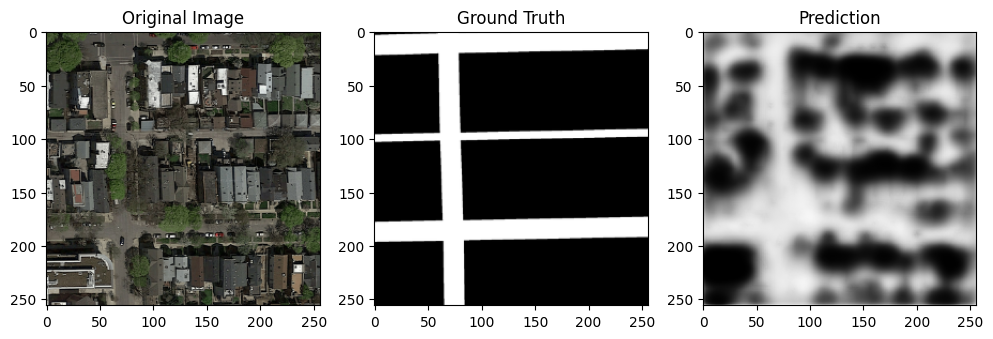

In [78]:
# Predict on the validation set
predictions_v3 = model_v3.predict(X_val_rgb)

# Visualize results
visualize_predictions(X_val_rgb, y_val, predictions_v3, idx=0)


### Enhancements in Trial 3:
* **Input Images are RGB:** The model now sees colored images for richer features.
* **Model Input Size Updated:** Input layer adjusted to (256, 256, 3) for RGB images.

---

## Trial 4: **Sliding Window** 

### Preprocessing

In [88]:
def sliding_window(image, mask=None, patch_size=128, stride=64):
    """
    Extracts overlapping patches from an image and mask using a sliding window.
    
    Args:
        image: Input image (H, W, C) or (H, W).
        mask: Corresponding mask (optional).
        patch_size: Size of the patch to extract (e.g., 128x128).
        stride: Step size for the sliding window (controls overlap).
    
    Returns:
        patches: List of image patches.
        mask_patches: List of corresponding mask patches (if mask is provided).
    """
    patches = []
    mask_patches = []

    h, w = image.shape[:2]
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            if mask is not None:
                mask_patch = mask[y:y + patch_size, x:x + patch_size]
                mask_patches.append(mask_patch)
    return patches, mask_patches

### Extract Patches from Training and Validation Data

In [89]:
PATCH_SIZE = 128  # Size of sliding window
STRIDE = 64       # Overlap between patches

# Extract patches for training
X_train_patches = []
y_train_patches = []

for img, mask in zip(X_train_rgb, y_train):
    img_patches, mask_patches = sliding_window(img, mask, patch_size=PATCH_SIZE, stride=STRIDE)
    X_train_patches.extend(img_patches)
    y_train_patches.extend(mask_patches)

# Convert to numpy arrays
X_train_patches = np.array(X_train_patches)
y_train_patches = np.array(y_train_patches)

print(f"Total training patches: {X_train_patches.shape}")
print(f"Total mask patches: {y_train_patches.shape}")


Total training patches: (720, 128, 128, 3)
Total mask patches: (720, 128, 128, 1)


In [90]:
X_val_patches = []
y_val_patches = []

for img, mask in zip(X_val_rgb, y_val):
    img_patches, mask_patches = sliding_window(img, mask, patch_size=PATCH_SIZE, stride=STRIDE)
    X_val_patches.extend(img_patches)
    y_val_patches.extend(mask_patches)

X_val_patches = np.array(X_val_patches)
y_val_patches = np.array(y_val_patches)


### Model Architecture (U-Net)

In [91]:
def unet_v4(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


model_v4 = unet_v4(input_size=(PATCH_SIZE, PATCH_SIZE, 3))
model_v4.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_v4.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128, 128,  │          0 │ conv2d_152[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 128, 128,  │     36,928 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 64, 64,    │          0 │ conv2d_153[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_29… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64, 64,    │          0 │ conv2d_154[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 64, 64,    │    147,584 │ dropout_21[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 32, 32,    │          0 │ conv2d_155[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_30… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32, 32,    │          0 │ conv2d_156[0][0]  │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 32, 32,    │    590,080 │ dropout_22[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 16, 16,    │          0 │ conv2d_157[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_31… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 16, 16,    │          0 │ conv2d_158[0][0]  │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ dropout_23[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_25    │ (None, 32, 32,    │          0 │ conv2d_159[0][0]

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model on Patches

In [93]:
history_v4 = model_v4.fit(X_train_patches, y_train_patches,
                          validation_data=(X_val_patches, y_val_patches),
                          batch_size=32, epochs=20)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 301s 13s/step - accuracy: 0.7569 - loss: 0.4342 - val_accuracy: 0.7684 - val_loss: 0.4751
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - accuracy: 0.7458 - loss: 0.4229 - val_accuracy: 0.7684 - val_loss: 0.4661
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.7467 - loss: 0.4033 - val_accuracy: 0.7684 - val_loss: 0.4009
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.7474 - loss: 0.3912 - val_accuracy: 0.7684 - val_loss: 0.3968
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.7469 - loss: 0.3790 - val_accuracy: 0.7530 - val_loss: 0.3949
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.7397 - loss: 0.3611 - val_accuracy: 0.7408 - val_loss: 0.3718
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.7165 - loss: 0.3385 - val_accuracy: 0.7216 - val_loss: 0.3774
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - accuracy: 0.7199 - loss: 0.3176 - val_accuracy: 0.7236 - 

In [119]:
# Save the new model
model_v4.save("model-4.keras")

### Visualize

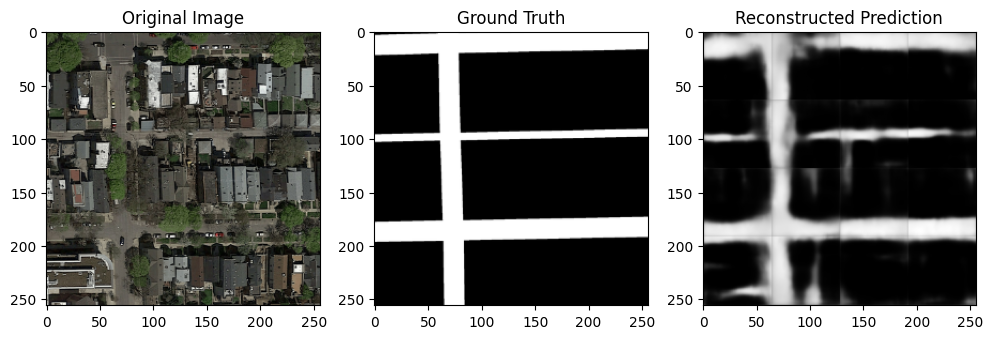

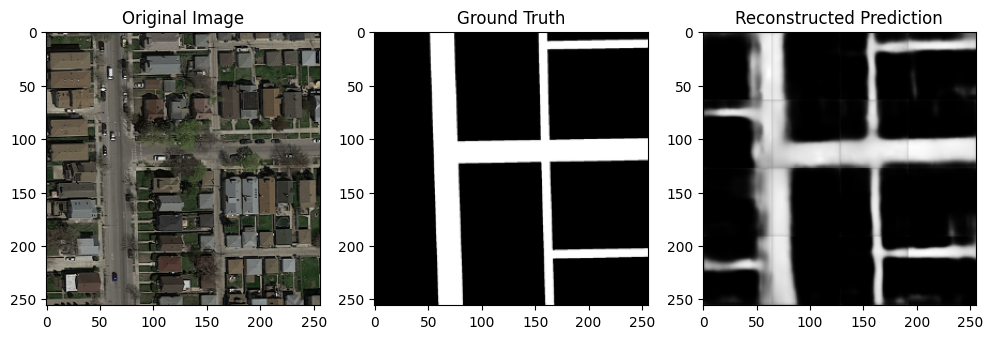

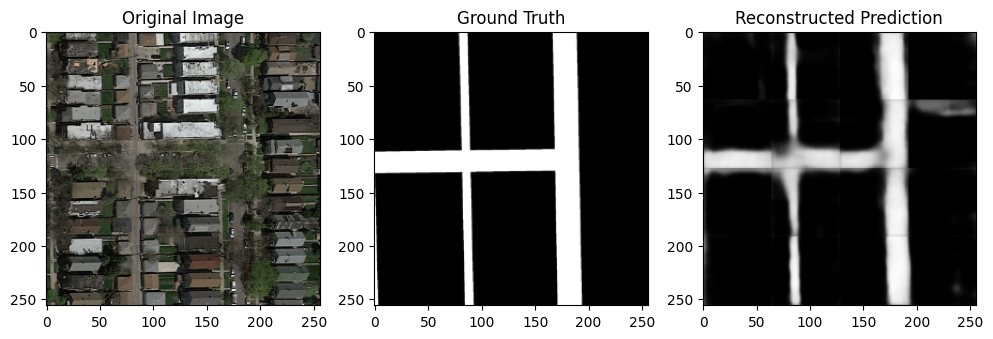

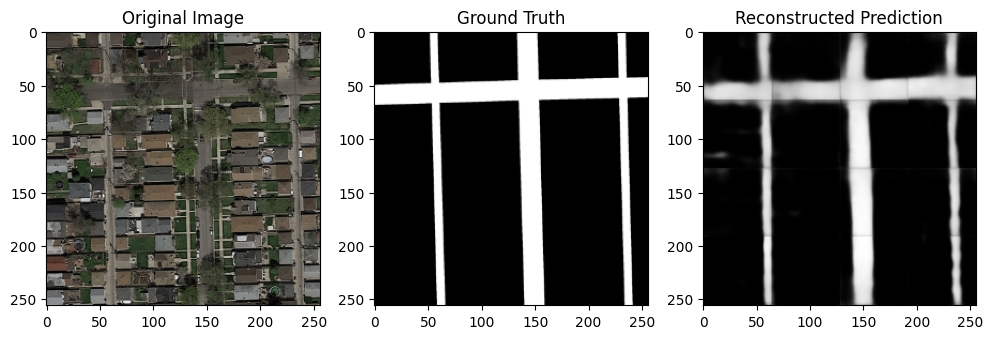

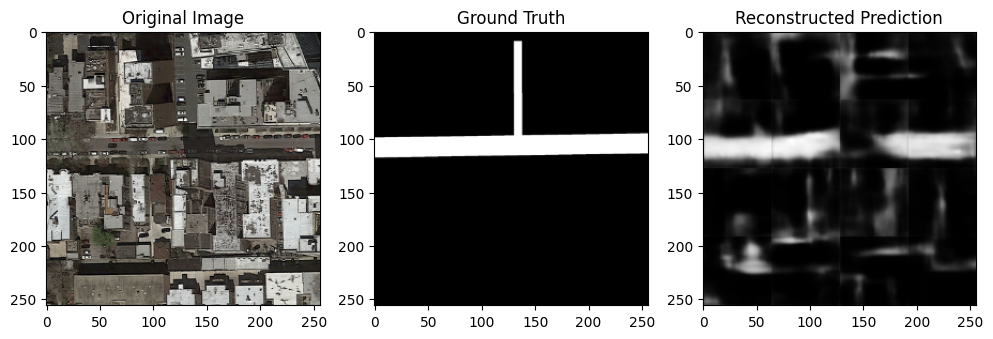

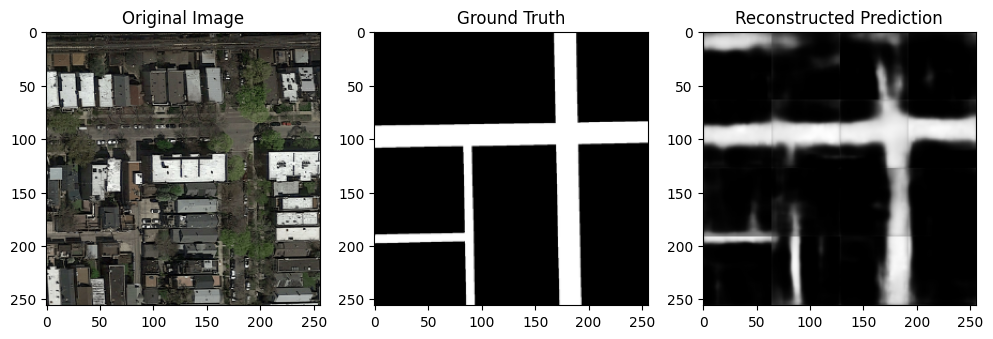

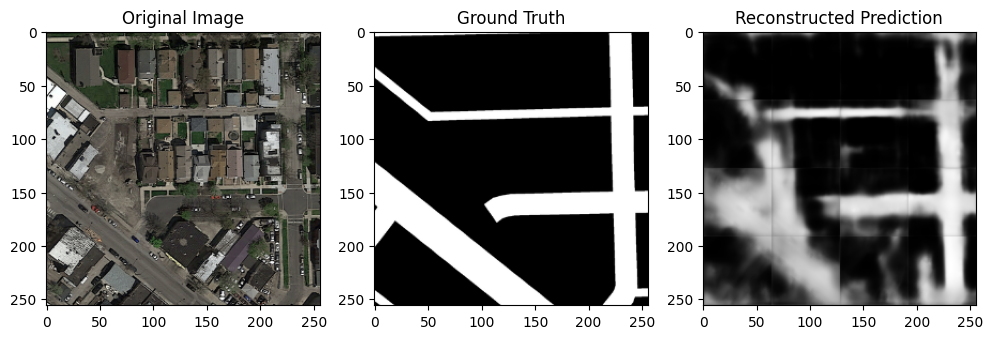

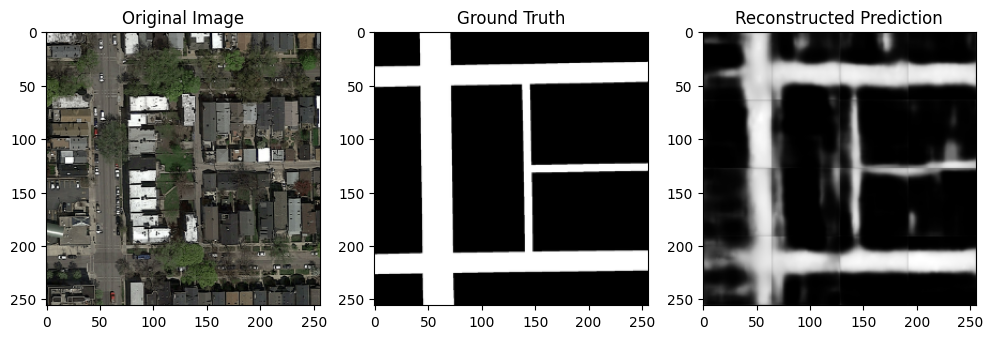

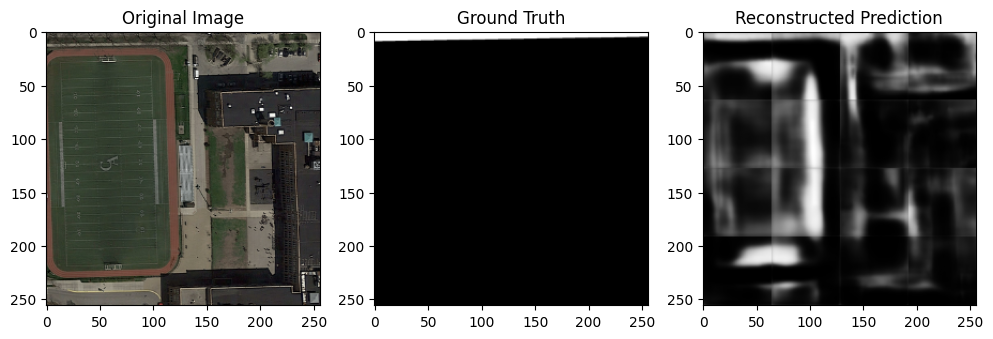

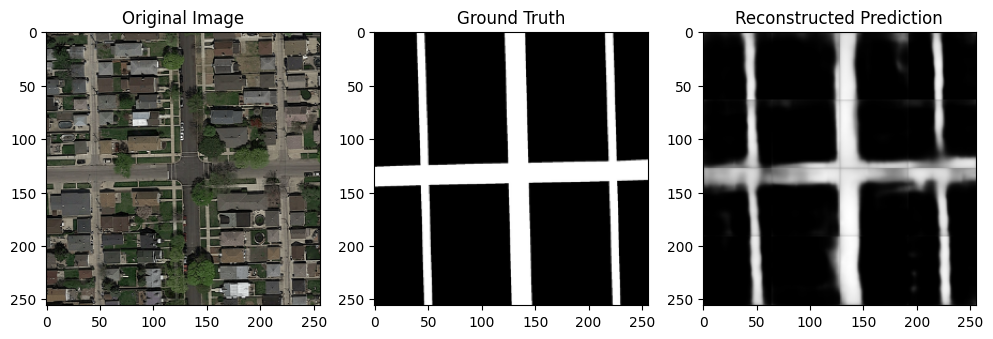

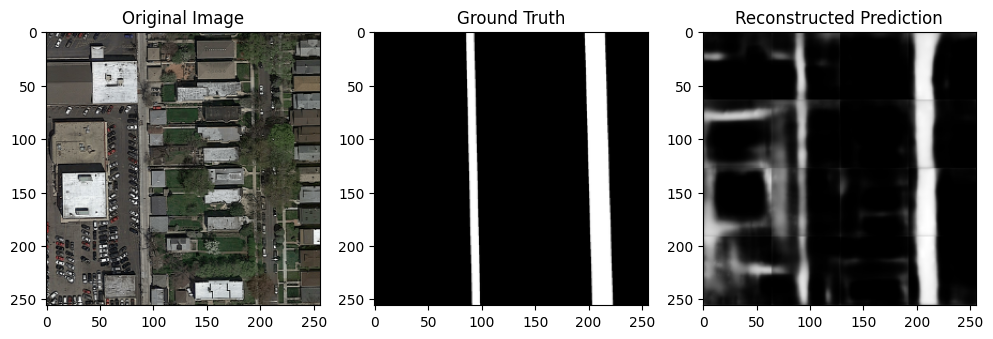

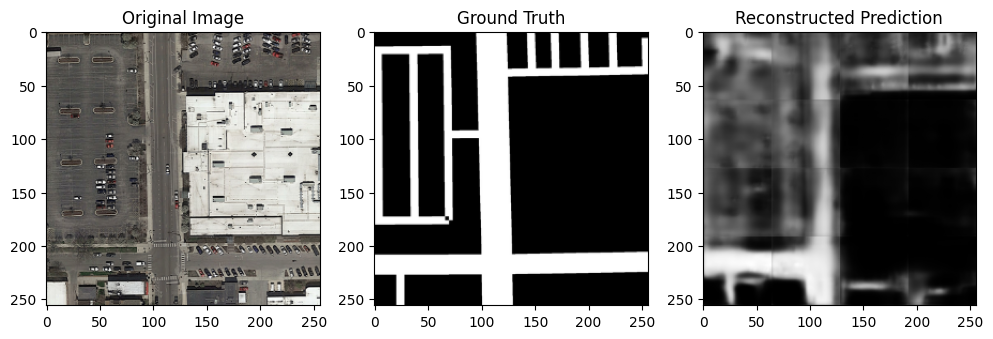

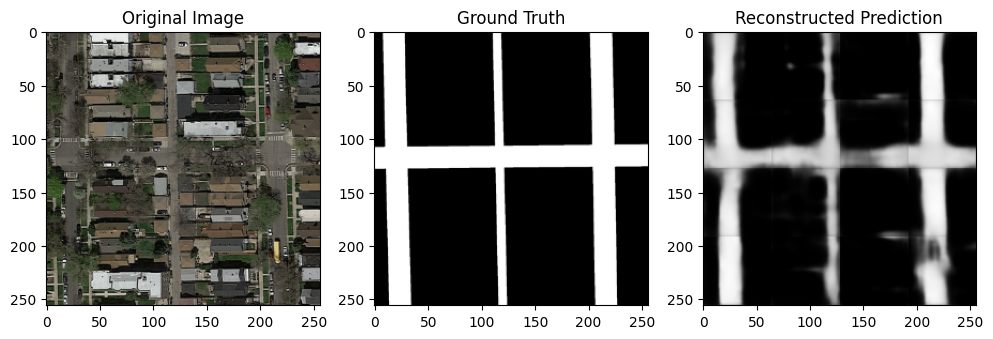

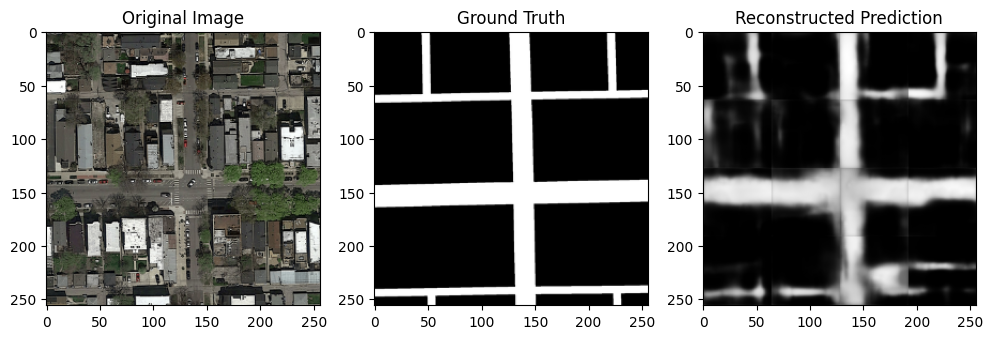

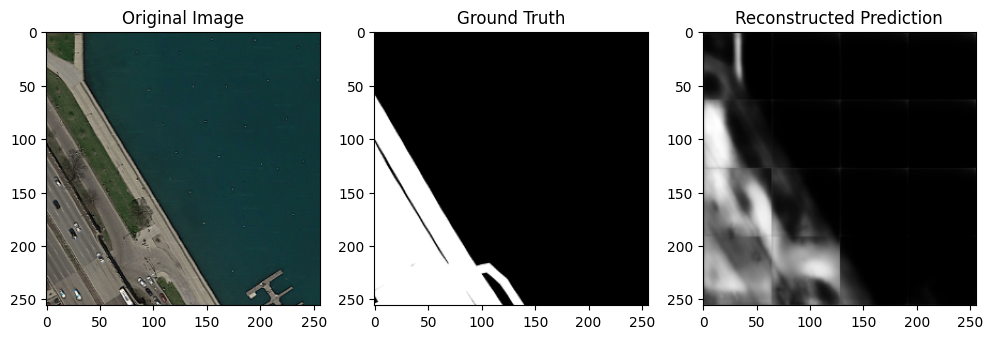

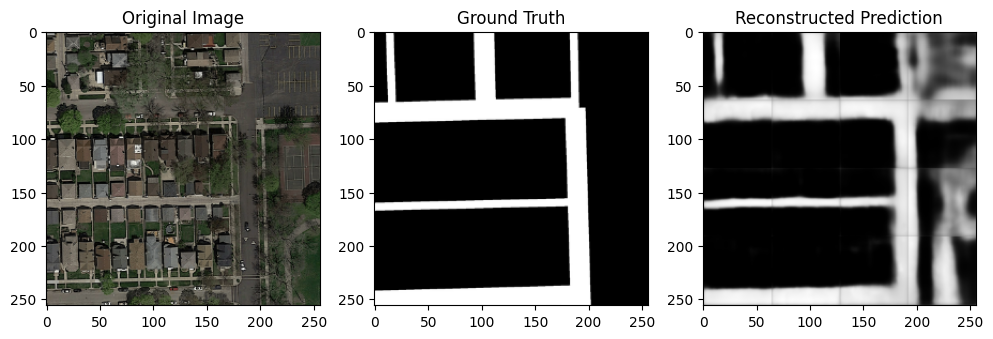

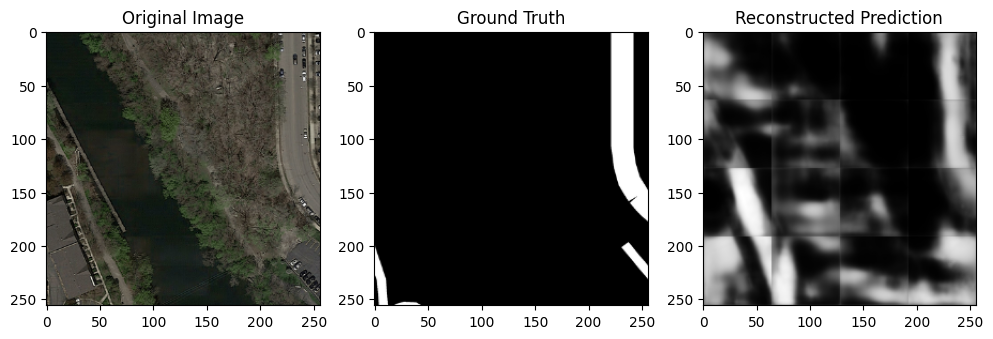

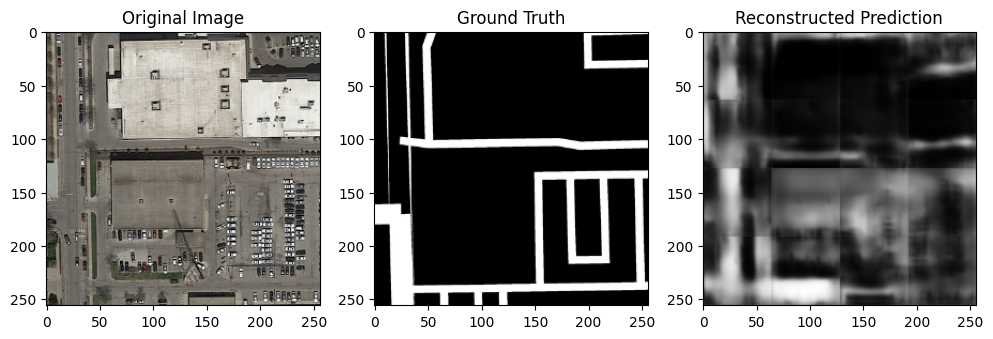

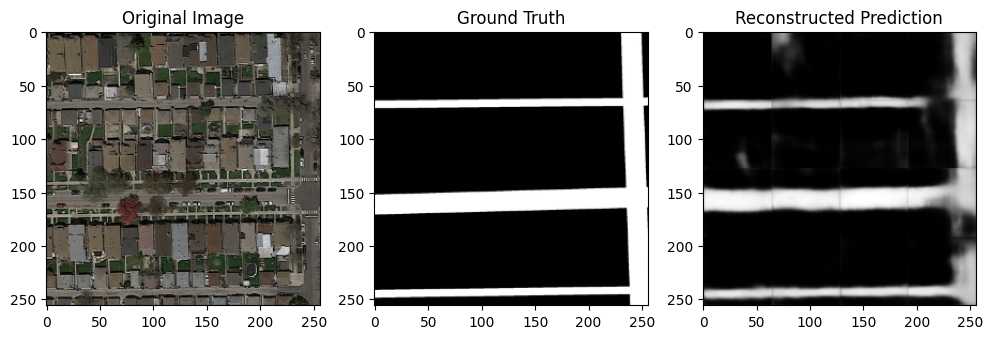

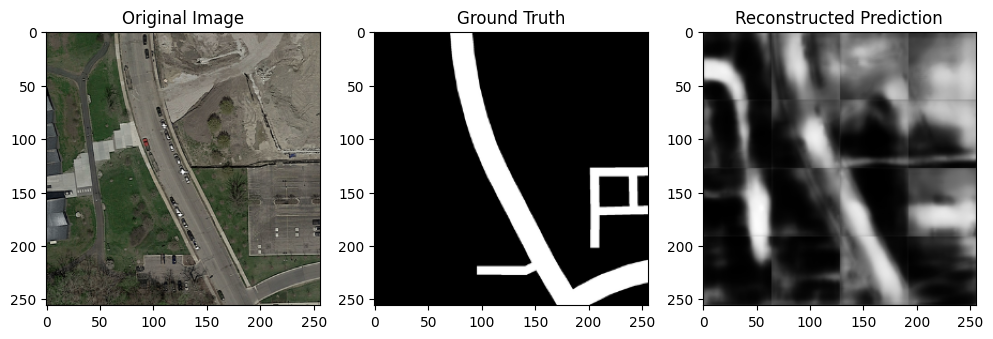

In [95]:
def reconstruct_image(patches, image_shape, patch_size=128, stride=64):
    """
    Reconstruct the full image from overlapping patches.
    """
    h, w = image_shape[:2]
    reconstructed = np.zeros((h, w))
    counts = np.zeros((h, w))

    idx = 0
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            reconstructed[y:y + patch_size, x:x + patch_size] += patches[idx].squeeze()
            counts[y:y + patch_size, x:x + patch_size] += 1
            idx += 1
    return reconstructed / counts

# Predict on validation images
for idx in range(len(X_val_rgb)):
    img_patches, _ = sliding_window(X_val_rgb[idx], patch_size=PATCH_SIZE, stride=STRIDE)
    img_patches = np.array(img_patches)
    predictions = model_v4.predict(img_patches, verbose=0)
    reconstructed_mask = reconstruct_image(predictions, X_val_rgb[idx].shape)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(X_val_rgb[idx])
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Prediction")
    plt.imshow(reconstructed_mask, cmap='gray')
    plt.show()

### Evaluation

In [98]:
from sklearn.metrics import f1_score

def calculate_f1(y_true, y_pred, threshold=0.5):
    """
    Calculates the F1 score for binary masks.
    
    Args:
        y_true: Ground truth masks (H, W).
        y_pred: Predicted masks (H, W).
        threshold: Threshold to binarize predicted masks.
        
    Returns:
        F1 score.
    """
    # Binarize both predictions and ground truth
    y_true_bin = (y_true > 0.5).astype(np.uint8)  # Ensure binary
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)  # Apply threshold
    
    # Flatten both masks
    y_true_flat = y_true_bin.flatten()
    y_pred_flat = y_pred_bin.flatten()
    
    # Calculate F1 score
    f1 = f1_score(y_true_flat, y_pred_flat)
    return f1


In [99]:
f1_scores = []

for idx in range(len(X_val_rgb)):
    # Get the sliding window predictions
    img_patches, _ = sliding_window(X_val_rgb[idx], patch_size=PATCH_SIZE, stride=STRIDE)
    img_patches = np.array(img_patches)
    predictions = model_v4.predict(img_patches, verbose=0)
    
    # Reconstruct the predicted mask
    reconstructed_mask = reconstruct_image(predictions, X_val_rgb[idx].shape)
    
    # Get ground truth mask
    ground_truth = y_val[idx].squeeze()
    
    # Calculate F1 score for this image
    f1 = calculate_f1(ground_truth, reconstructed_mask)
    f1_scores.append(f1)
    print(f"Image {idx+1} F1 Score: {f1:.4f}")

# Calculate average F1 score
average_f1 = np.mean(f1_scores)
print(f"Average F1 Score on Validation Set: {average_f1:.4f}")


Image 1 F1 Score: 0.8766
Image 2 F1 Score: 0.8940
Image 3 F1 Score: 0.8693
Image 4 F1 Score: 0.9269
Image 5 F1 Score: 0.7432
Image 6 F1 Score: 0.7615
Image 7 F1 Score: 0.7326
Image 8 F1 Score: 0.8328
Image 9 F1 Score: 0.3053
Image 10 F1 Score: 0.9024
Image 11 F1 Score: 0.7434
Image 12 F1 Score: 0.4622
Image 13 F1 Score: 0.8863
Image 14 F1 Score: 0.7822
Image 15 F1 Score: 0.5342
Image 16 F1 Score: 0.7888
Image 17 F1 Score: 0.3749
Image 18 F1 Score: 0.2674
Image 19 F1 Score: 0.8563
Image 20 F1 Score: 0.3610
Average F1 Score on Validation Set: 0.6951


### Enhancements in Trial 4:
* **Sliding Window:** Images are processed in smaller overlapping patches to focus on local regions.
* **Patch-Based Training:** Patches improve model performance on fine details like roads.
* **Reconstructed Predictions:** Stitching overlapping predictions back into a single mask improves accuracy.


- `Sliding Window` Techique Achieved The Best Results.

### Preparing the Submission File

In [ ]:
import pandas as pd

TEST_DATA_PATH = "data/test_set_images"  # Path to test images folder
SAMPLE_SUBMISSION_FILE = "data/sample_submission.csv"  # Path to sample file
OUTPUT_FILE = "trial_4_submission.csv"  # Final output file

# Load the sample submission file to keep IDs intact
submission_df = pd.read_csv(SAMPLE_SUBMISSION_FILE)
print(submission_df.head())


         id  prediction
0   001_0_0           1
1  001_0_16           0
2  001_0_32           0
3  001_0_48           1
4  001_0_64           1


In [101]:
def predict_patches_and_save(model, test_data_path, patch_size=128, stride=64, threshold=0.5):
    """
    Predict road segmentation on test images and save in submission format.
    """
    predictions = []  # List to store patch predictions

    # Loop through all test folders (test_1, test_2, ..., test_50)
    for idx in range(1, 51):  # test images 1 to 50
        test_image_path = os.path.join(test_data_path, f"test_{idx}", f"test_{idx}.png")
        
        # Load the test image as RGB
        test_img = img_to_array(load_img(test_image_path)) / 255.0
        original_shape = test_img.shape[:2]
        
        # Extract patches
        img_patches, _ = sliding_window(test_img, patch_size=patch_size, stride=stride)
        img_patches = np.array(img_patches)
        
        # Predict for each patch
        patch_preds = model.predict(img_patches, verbose=0)
        reconstructed_mask = reconstruct_image(patch_preds, original_shape, patch_size=patch_size, stride=stride)
        
        # Binarize predictions
        binary_mask = (reconstructed_mask >= threshold).astype(np.uint8)
        
        # Process the binary mask to extract 16x16 patches and assign labels
        patch_size_submission = 16
        for j in range(0, original_shape[1], patch_size_submission):
            for i in range(0, original_shape[0], patch_size_submission):
                patch = binary_mask[i:i + patch_size_submission, j:j + patch_size_submission]
                label = int(np.mean(patch) > 0.25)  # Threshold for patch labeling
                predictions.append(label)

    return predictions


In [102]:
# Run predictions
predicted_labels = predict_patches_and_save(model_v4, TEST_DATA_PATH, patch_size=128, stride=64, threshold=0.5)

# Fill in the predictions column of the sample submission file
submission_df["prediction"] = predicted_labels

# Save to a new CSV file
submission_df.to_csv(OUTPUT_FILE, index=False)
print(f"Submission file saved to: {OUTPUT_FILE}")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5960\1678596309.py:15: RuntimeWarning: invalid value encountered in divide
  return reconstructed / counts


Submission file saved to: submission.csv
